In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split
# from rfpimp import *
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.head())
print(test.head())

          ID  Estimated_Insects_Count  ...  Season  Crop_Damage
0  F00000001                      188  ...       1            0
1  F00000003                      209  ...       2            1
2  F00000004                      257  ...       2            1
3  F00000005                      257  ...       2            1
4  F00000006                      342  ...       2            1

[5 rows x 10 columns]
          ID  Estimated_Insects_Count  ...  Number_Weeks_Quit  Season
0  F00000002                      188  ...                  0       2
1  F00000007                      410  ...                  0       2
2  F00000011                      626  ...                  0       2
3  F00000013                      731  ...                  0       2
4  F00000014                      789  ...                  0       1

[5 rows x 9 columns]


In [3]:
train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       88858 non-null  object 
 1   Estimated_Insects_Count  88858 non-null  int64  
 2   Crop_Type                88858 non-null  int64  
 3   Soil_Type                88858 non-null  int64  
 4   Pesticide_Use_Category   88858 non-null  int64  
 5   Number_Doses_Week        88858 non-null  int64  
 6   Number_Weeks_Used        79858 non-null  float64
 7   Number_Weeks_Quit        88858 non-null  int64  
 8   Season                   88858 non-null  int64  
 9   Crop_Damage              88858 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 6.8+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59310 entries, 0 to 59309
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       59310 non-null  object 
 1   Estimated_Insects_Count  59310 non-null  int64  
 2   Crop_Type                59310 non-null  int64  
 3   Soil_Type                59310 non-null  int64  
 4   Pesticide_Use_Category   59310 non-null  int64  
 5   Number_Doses_Week        59310 non-null  int64  
 6   Number_Weeks_Used        53417 non-null  float64
 7   Number_Weeks_Quit        59310 non-null  int64  
 8   Season                   59310 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 4.1+ MB


In [6]:
d1=train.isnull().sum().to_frame().rename(columns={0: "Train_Null_Values"})
d2=test.isnull().sum().to_frame().rename(columns={0: "Test_Null_Values"})
d3=train.dtypes.to_frame().rename(columns={0: "Data_Type"})
pd.concat([d1, d2,d3], axis=1)

,Train_Null_Values,Test_Null_Values,Data_Type
ID,0,0.0,object
Estimated_Insects_Count,0,0.0,int64
Crop_Type,0,0.0,int64
Soil_Type,0,0.0,int64
Pesticide_Use_Category,0,0.0,int64
Number_Doses_Week,0,0.0,int64
Number_Weeks_Used,9000,5893.0,float64
Number_Weeks_Quit,0,0.0,int64
Season,0,0.0,int64
Crop_Damage,0,NaN,int64


EDA

In [7]:
train['Crop_Damage'].value_counts(normalize=True)

0    0.835468
1    0.138502
2    0.026030
Name: Crop_Damage, dtype: float64

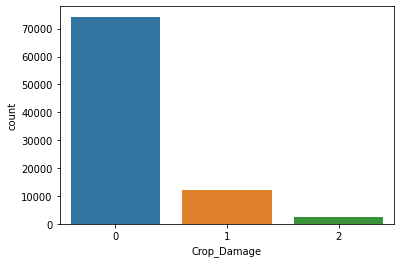

In [8]:
sns.countplot(train["Crop_Damage"])

In [9]:
train.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
count,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,79858.000000,88858.000000,88858.000000,88858.000000
mean,1399.012210,0.284375,0.458417,2.264186,25.849952,28.623970,9.589986,1.896959,0.190562
std,849.048781,0.451119,0.498271,0.461772,15.554428,12.391881,9.900631,0.701322,0.454215
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000


In [10]:
train.fillna(40, inplace = True)

In [11]:
test.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
count,59310.000000,59310.000000,59310.000000,59310.000000,59310.000000,53417.000000,59310.000000,59310.000000
mean,1397.014129,0.287068,0.455117,2.263227,25.851880,28.705094,9.528376,1.900877
std,849.425808,0.452397,0.497986,0.461733,15.481957,12.421211,9.855341,0.701934
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,38.000000,16.000000,2.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000


In [12]:
test.fillna(40, inplace = True)

In [13]:
train.head(2)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1


In [14]:
train = train.astype(int, errors='ignore')

In [15]:
# extracting highly correlated columns(except target variable) to drop

# Create correlation matrix
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
cols_to_drop

[]

In [16]:
X_train = train.drop(columns=['Crop_Damage','ID'],axis=1)
y = train['Crop_Damage']
X_test = test.drop(columns=['ID'],axis=1)

In [17]:
X_train.shape

(88858, 8)

In [18]:
X_test.shape

(59310, 8)

In [60]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(random_state=27, max_depth=6, n_estimators=3000)
model.fit(X_train, y)
preds1 = model.predict(X_test)

In [61]:
print(preds1)

[1 1 1 ... 1 0 0]


In [20]:
sub = pd.read_csv('sample_submission.csv')
ids = sub["ID"].values

In [63]:
#res.index = test.index # its important for comparison
res = pd.DataFrame({'ID': ids, 'Crop_Damage': preds1})
res.to_csv("three.csv", index = False)

In [23]:
!pip install catboost

     |████████████████████████████████| 64.8MB 60kB/s 


In [26]:
!pip install ipywidgets

In [39]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(random_state=27, n_estimators=1000, max_depth=4, verbose=500)
cat_model.fit(X_train, y)
preds2 = cat_model.predict(X_test)
print(preds2)
#cat_df = pd.DataFrame({'ID': ids, 'Crop_Damage': preds2})
#cat_df.to_csv("cat.csv")


Learning rate set to 0.099473
0:	learn: 0.9812302	total: 38.6ms	remaining: 38.6s
500:	learn: 0.4133555	total: 19.5s	remaining: 19.4s
999:	learn: 0.4082373	total: 38.8s	remaining: 0us
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [40]:
print(preds2.shape)

(59310, 1)


In [45]:
x = np.squeeze(preds2)

In [49]:
print(x)
print(x.dtype)

[1 1 1 ... 0 0 0]
int64


In [50]:
cat_df = pd.DataFrame({'ID': ids, 'Crop_Damage': x})
cat_df.to_csv("cat.csv")

In [55]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=600)
rf_model.fit(X_train, y)
rf = rf_model.predict(X_test)
print(rf)

[1 1 1 ... 1 0 0]


In [56]:
rf_df = pd.DataFrame({'ID': ids, 'Crop_Damage': rf}, index=None)
rf_df.to_csv("rf.csv", index = False)

In [59]:
from xgboost import XGBClassifier
xg_model = XGBClassifier(n_estimators=2000)
xg_model.fit(X_train, y)
xg = xg_model.predict(X_test)
print(xg)
xg_df = pd.DataFrame({'ID': ids, 'Crop_Damage': xg})
xg_df.to_csv("xg2.csv", index = False)

[1 1 1 ... 1 0 0]


In [47]:
preds = list()
cb_weight=0.4 # Catboost
lb_weight=0.6 # LGBM
for i, j in zip(preds1, x):
    xx = [(cb_weight * i[0]) + (lb_weight * j[0]),
          (cb_weight * i[1]) + (lb_weight * j[1]),
          (cb_weight * i[2]) + (lb_weight * j[2])]
    preds.append(xx)
print(preds[:10])


IndexError: ignored